In [60]:
'''
Trying to improve the dcan_signal_processing.m by doing it in python and getting rid of all the CIFTI I/O done through wb_command
'''

'\nTrying to improve the dcan_signal_processing.m by doing it in python and getting rid of all the CIFTI I/O done through wb_command\n'

In [16]:
import json
import math
import os
import nibabel as nib
import pandas as pd
import numpy as np
import scipy
import subprocess
from subprocess import check_call
from glob import glob
import sys
import matplotlib.pyplot as plt  # If checking the output

In [102]:
json_path = r"/data/wheelock/data1/datasets/BCP/Example_BCP_intermediates/sub-100619/output_Tu/MNINonLinear/Results/ses-17mo_task-rest_run-001/DCANBOLDProc_vTu1.0/DCANBOLDProc_vTu1.0_mat_config.json"
# Load the json file
with open(json_path, 'r') as file:
    json_input = json.load(file)
globals().update(json_input) # unwraps the dictionary into global variables (Line 9 in dcan_signal_processing.m)

In [103]:
json_input

{'FNL_preproc_CIFTI_basename': 'ses-17mo_task-rest_run-001_DCANBOLDProc_vTu1.0_Atlas',
 'TR': 0.8,
 'bp_order': 2,
 'fMRIName': 'ses-17mo_task-rest_run-001',
 'fd_th': 0.3,
 'file_mov_reg': '/data/wheelock/data1/datasets/BCP/Example_BCP_intermediates/sub-100619/output_Tu/MNINonLinear/Results/ses-17mo_task-rest_run-001/DCANBOLDProc_vTu1.0/DCANBOLDProc_vTu1.0_bs16.8896_28.6662_filtered_Movement_Regressors.txt',
 'file_vent': '/data/wheelock/data1/datasets/BCP/Example_BCP_intermediates/sub-100619/output_Tu/MNINonLinear/Results/ses-17mo_task-rest_run-001/DCANBOLDProc_vTu1.0/ses-17mo_task-rest_run-001_vent_mean.txt',
 'file_wm': '/data/wheelock/data1/datasets/BCP/Example_BCP_intermediates/sub-100619/output_Tu/MNINonLinear/Results/ses-17mo_task-rest_run-001/DCANBOLDProc_vTu1.0/ses-17mo_task-rest_run-001_wm_mean.txt',
 'hp_Hz': 0.08,
 'lp_Hz': 0.009,
 'motion_filename': 'motion_numbers.txt',
 'path_cii': '/data/wheelock/data1/datasets/BCP/Example_BCP_intermediates/sub-100619/output_Tu/MNINonL

In [286]:
# Dependency functions

def calculate_dvars_from_cifti(data):
    """
    This function calculates DVARS (Derivative of Variance) based on grayordinates (WM and non-brain excluded).
    
    Parameters:
    data (ndarray): 2D numpy array with shape (tr, g), where g represents the number of grayordinates and tr is the number of time points.
    
    Returns:
    dvars (float): The calculated DVARS value.
    """
    # Check size and transpose if needed
    num_timepoints,num_grayordinates  = data.shape
    if num_grayordinates < num_timepoints:
            data = data.T
            print('data transposed due to timepoints > grayordinates, double check input')

    # Calculate differences across timepoints
    data_diff = np.diff(data, axis=0)

    # Calculate DVARS as the root mean square of the differences
    dvars = np.sqrt(np.mean(data_diff ** 2,axis=1))

    return dvars

def filter_movement_regressors(signal, TR, order, filt_type, fc_RR_min, fc_RR_max):   
    fs = 1 / TR
    fNy = fs / 2 # Nyquist frequency
    if filt_type == 'lp':
        freq_low = fc_RR_min / 60 # Hz lower range
        b_filt,a_filt = scipy.signal.butter(order,freq_low/fNy,'lowpass',axis = 0)
    elif filt_type == 'notch':
        freq_low = fc_RR_min / 60  # Hz, lower range
        freq_high = fc_RR_max / 60  # Hz, higher range
        b_filt,a_filt = scipy.signal.butter(order,np.array([freq_low,freq_high])/fNy,'bandstop')
    
    filtered_signal = scipy.signal.filtfilt(b_filt,a_filt,signal,axis = 0)   

    return filtered_signal

def calc_FD(R, FD_type=1, hd_mm=50):
    R = R[:,:6].copy()
    R[:, 3:] *= hd_mm * (np.pi / 180)  # Convert degrees to mm, assuming head diameter

    dR = np.diff(R,axis = 0) # First-order derivative
    ddR = np.diff(dR,axis = 0)  # Second-order derivative
    if FD_type == 1:
        # L1-norm - sum of absolute values of first-order derivatives
        FD = np.sum(np.absolute(dR), axis=1) 
        meanFD = np.mean(FD)
        FD = np.hstack((np.zeros(1,),FD)) # Pad zeros to make it the same length as the original data
    elif FD_type == 2:
        # L2-norm - sum of absolute values of second-order derivatives
        FD = np.sum(np.absolute(ddR),axis=1)
        meanFD = np.mean(FD)
        FD = np.hstack((np.zeros(2,),FD))# Pad zeros to make it the same length as the original data
    return FD,meanFD 

def make_friston_regressors(MR, hd_mm=50):
    """
    This function takes a matrix `MR` of 6 degrees of freedom (DOF) movement correction
    parameters and calculates the corresponding 24 Friston regressors.

    Parameters:
    -----------
    MR : numpy array of shape (r, c)
        A matrix where r is the number of time points and c are the 6 DOF movement regressors.
        If the number of columns is more than 6, only the first 6 columns are considered.

    head_ratio_cm : float, optional
        The head ratio in cm. Default is 5 cm.

    Returns:
    --------
    FR : numpy array of shape (r, 24)
        A matrix containing 24 Friston regressors.
    """

    # Only consider the first 6 columns of MR
    MR = MR[:, :6]

    # Convert rotational motion parameters (4th to 6th columns) from degrees to arc length in mm
    MR[:, 3:] = MR[:, 3:] * np.pi * hd_mm / 180

    # Calculate the first part of the Friston regressors (MR and MR^2)
    FR = np.hstack([MR, MR**2])

    # Create a dummy array for the temporal derivatives (lagged version of FR)
    dummy = np.zeros_like(FR)
    dummy[1:, :] = FR[:-1, :]  # shift FR by one time step
    dummy[0, :] = 0  # set the first row to 0

    # Concatenate the original FR and the lagged version
    FR = np.hstack([FR, dummy])

    return FR

def calc_power_spectrum(data):
    assert len(data.shape) == 1 or data.shape[1] == 1,"Input has to be a column vector or 1D array"
    N = data.shape[0]
    yf = scipy.fftpack.fft(data)
    power_spectrum = 2.0 / N * np.abs(yf[0 : N // 2])
    return power_spectrum

In [7]:
# Get TR (Line 34 in dcan_signal_processing.m)
TR = nib.load(path_cii).header.get_axis(0).step  # In seconds
if TR>20: # handle niftis that store TR in ms 
    TR /= 1000
print('TR = ' + str(TR))
skip_frames = math.floor(skip_seconds/TR)

TR = 0.8


In [29]:
# Read cifti data (Line 43 in dcan_signal_processing)
img = nib.load(path_cii)
data = img.get_fdata()
DVAR_pre_reg = calculate_dvars_from_cifti(data)
plt.plot(DVAR_pre_reg)

In [79]:
# Read white matter and ventricles data (Line 52 in dcan_bold_processing.m)
wm = np.loadtxt(file_wm)
vent = np.loadtxt(file_vent)

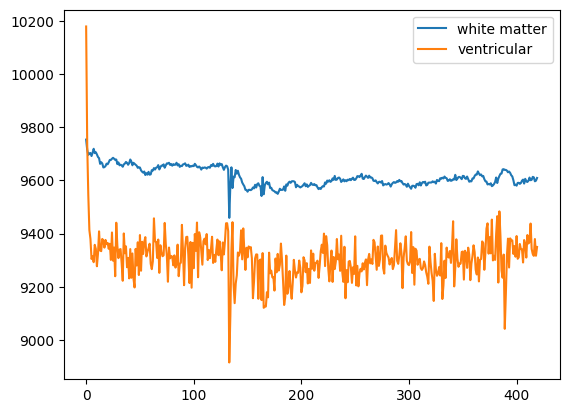

In [80]:
# Visualization
plt.plot(wm,label='white matter')
plt.plot(vent,label='ventricular')
plt.legend()

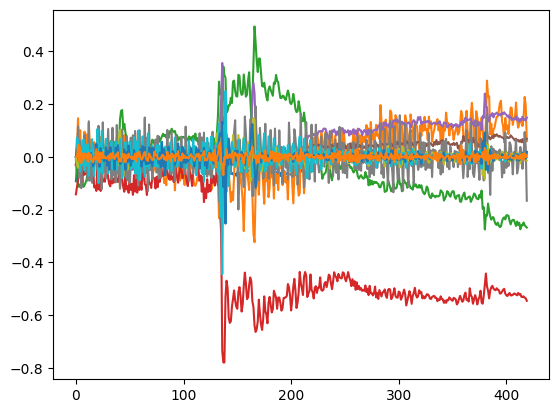

In [337]:
# Filter movement regressors
assert os.path.isfile(file_mov_reg), 'movement regressor file not found' 
unfiltered_mov_regressors = np.loadtxt(file_mov_reg)
filtered_mov_regressors = filter_movement_regressors(unfiltered_mov_regressors, TR, motion_filter_order, motion_filter_type, band_stop_min, band_stop_max)
plt.plot(filtered_mov_regressors)
plt.show()

In [339]:
# Calculate FD  (Line 73 in dcan_bold_processing.m)
FD,meanFD = calc_FD(filtered_mov_regressors,FD_type=FD_type,hd_mm=brain_radius_mm)
FD_file_name = os.path.join(result_dir,FNL_preproc_CIFTI_basename + '_FD.txt')
np.savetxt(FD_file_name,FD)
print('Mean FD = ' + str(meanFD))

Mean FD = 0.13426696557929402


In [354]:
# Now state the frames to keep for the processing
keepframe = FD <= fd_th
skip_frames = np.int8(np.floor(skip_seconds/TR))
keepframe[:skip_frames]=False

400

In [ ]:
# demean/detrend on CIFTI and movement regressors


### Compare the DCAN-MATLAB filtered movement parameters and Tu-Python filtered movement parameters ###

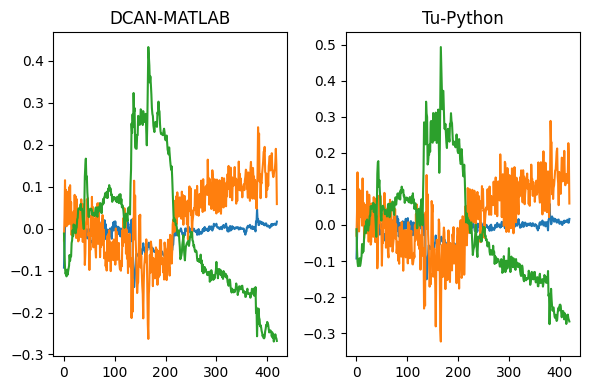

In [ ]:
#file_mov_reg = '/data/wheelock/data1/datasets/BCP/Example_BCP_intermediates/sub-100619/output_Tu/MNINonLinear/Results/ses-17mo_task-rest_run-001/DCANBOLDProc_vTu1.0/DCANBOLDProc_vTu1.0_bs16.8896_28.6662_filtered_Movement_Regressors.txt'
file_mov_reg = '/data/wheelock/data1/datasets/BCP/Example_BCP_intermediates/sub-100619/output_Tu/MNINonLinear/Results/ses-17mo_task-rest_run-001/Movement_Regressors_filtered_matlabscript.txt'
dcan_filtered_signal = np.loadtxt(file_mov_reg)
plt.figure(figsize=(6,4))
plt.subplot(1,2,1)
plt.plot(dcan_filtered_signal[:,:3])
plt.title('DCAN-MATLAB')
file_mov_reg = '/data/wheelock/data1/datasets/BCP/Example_BCP_intermediates/sub-100619/output_Tu/MNINonLinear/Results/ses-17mo_task-rest_run-001/Movement_Regressors.txt'
unfiltered_mov_regressors = np.loadtxt(file_mov_reg)
filtered_mov_regressors = filter_movement_regressors(unfiltered_mov_regressors, TR, motion_filter_order, motion_filter_type, band_stop_min, band_stop_max)
plt.subplot(1,2,2)
plt.plot(filtered_mov_regressors[:,:3])
plt.title('Tu-Python')
# N.B. The columns 4-6 (and 9-12) are not directly comparable to DCAN because rotations are in degrees not arc length
plt.tight_layout()
plt.show()

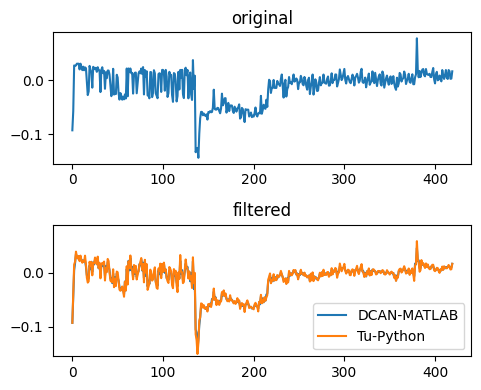

In [ ]:
plt.figure(figsize=(5, 4)) 
plt.subplot(2,1,1)
plt.plot(unfiltered_mov_regressors[:,0])
ylims =plt.gca().get_ylim()
plt.title('original')
plt.subplot(2,1,2)
plt.plot(dcan_filtered_signal[:,0],label='DCAN-MATLAB')
plt.plot(filtered_mov_regressors[:,0],label='Tu-Python')
plt.ylim(ylims)
plt.title('filtered')
plt.legend()
plt.tight_layout()
plt.show()

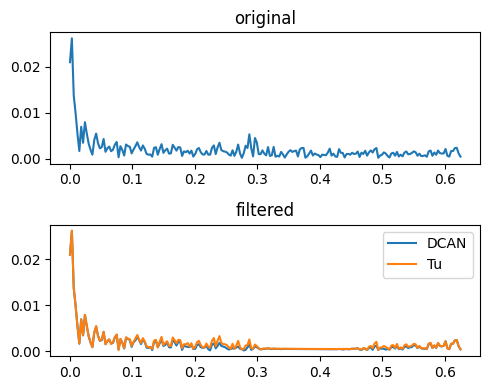

In [ ]:
fs = 1 / TR  # Sampling frequency: 1 frame per 0.8 seconds => 1.25 Hz
N = unfiltered_mov_regressors.shape[0]  # Number of data points
xf = np.linspace(0.0, fs / 2.0, N // 2)

# Compute power spectrum
power_spectrum = calc_power_spectrum(unfiltered_mov_regressors[:,0])
power_spectrum_filtered_DCAN = calc_power_spectrum(dcan_filtered_signal[:,0])
power_spectrum_filtered_Tu = calc_power_spectrum(filtered_mov_regressors[:,0])


plt.figure(figsize=(5, 4))  
plt.subplot(2,1,1)
plt.plot(xf,power_spectrum)
plt.title('original')
ylims =plt.gca().get_ylim()
plt.subplot(2,1,2)
plt.plot(xf,power_spectrum_filtered_DCAN,label='DCAN')
plt.plot(xf,power_spectrum_filtered_Tu,label='Tu')
plt.title('filtered')
plt.ylim(ylims)
plt.legend()
plt.tight_layout()
plt.show()

### Compare the DCAN-MATLAB FD and Tu-Python FD
DCAN-MATLAB FD had a bug where it assumed the columns 4-6 are in degrees but the filtered movement parameters they saved was already in arc length

In [332]:
from scipy.io import loadmat
FD_DCAN = loadmat('/data/wheelock/data1/datasets/BCP/Example_BCP_intermediates/sub-100619/output_Tu/MNINonLinear/Results/ses-17mo_task-rest_run-001/DCANBOLDProc_vTu1.0/FD.mat')['FD'].squeeze()
path_mov_reg = '/data/wheelock/data1/datasets/BCP/Example_BCP_intermediates/sub-100619/output_Tu/MNINonLinear/Results/ses-17mo_task-rest_run-001/Movement_Regressors.txt'
unfiltered_mov_regressors = np.loadtxt(path_mov_reg)
filtered_mov_regressors = filter_movement_regressors(unfiltered_mov_regressors[:,:6], TR, motion_filter_order, motion_filter_type, band_stop_min, band_stop_max)
FD,meanFD = calc_FD(filtered_mov_regressors,1)
filtered_mov_regressors_arclength = filtered_mov_regressors
filtered_mov_regressors_arclength[:,3:] = filtered_mov_regressors[:,3:]*np.pi*brain_radius_mm/180
FD_arclength,meanFDarclength = calc_FD(filtered_mov_regressors_arclength,1)

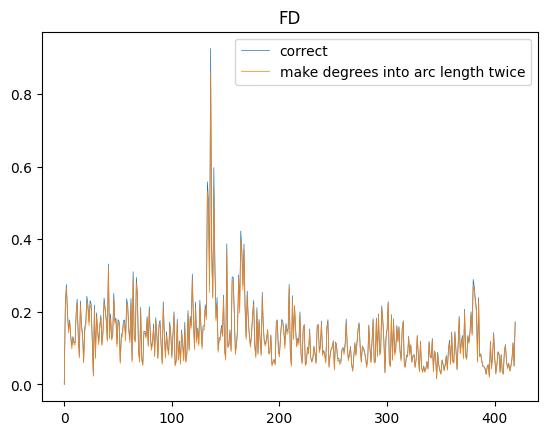

(0.13426696557929402, 0.12807021413115396)


In [333]:
# Effect of calculating arc length twice (reduces FD but effect is small when the movement is small)
plt.plot(FD,label='correct',linewidth=0.5)
plt.plot(FD_arclength,label='make degrees into arc length twice',linewidth=0.5)
plt.legend()
plt.title('FD')
plt.show()
print((meanFD,meanFDarclength))

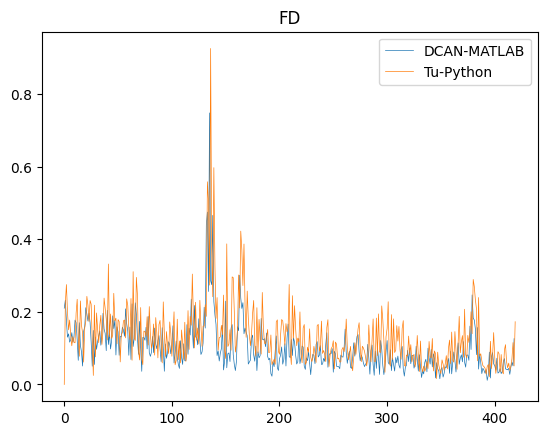

(0.1006131561495051, 0.13426696557929402)
414 406


In [355]:
# Compare the saved DCAN output with the python output (note that there are differences in the filter too)
plt.plot(FD_DCAN, label='DCAN-MATLAB',linewidth=0.5)
plt.plot(FD,label='Tu-Python',linewidth=0.5)
plt.legend()
plt.title('FD')
plt.show()
print((np.mean(FD_DCAN),meanFD))
print(np.sum(FD_DCAN < fd_th),np.sum(FD < fd_th))